<div style="text-align: right">Peter Norvig, 3 Oct 2015, revised 27 Oct 2015, translated to Julia by Mohammed El-Beltagy 27 Nov 2015</div> 

# Probability, Paradox, and the Reasonable Person Principle

*This notebook is a Julia translation of [Norvig's Original Notebook](http://nbviewer.ipython.org/url/norvig.com/ipython/Probability.ipynb). Python generators were replaced by Julia's coroutines. When dealing with
changing input types, I used Julia's multiple dispatch instead of checking for
types inside a function. Norvig's description and original text is only
changes when the results are slightly different is some simulations. *

In this notebook, we cover the basics of probability theory, and show how to implement the theory in Julia. (You should have a little background in [probability](http://www.dartmouth.edu/~chance/teaching_aids/books_articles/probability_book/pdf.html) and [Julia](http://julialang.org/learning/).) Then we show how to solve some particularly perplexing paradoxical probability problems.

Over 200 years ago, Pierre-Simon Laplace [wrote](https://en.wikipedia.org/wiki/Classical_definition_of_probability):

>The probability of an event is the ratio of the number of cases favorable to it, to the number of all cases possible, when [the cases are] equally possible. ... Probability is thus simply a fraction whose numerator is the number of favorable cases and whose denominator is the number of all the cases possible.

Laplace really nailed it, way back then. If you want to untangle a probability problem (paradoxical or not), all you have to do is be methodical about defining exactly what the cases are, and then careful in counting the number of favorable and total cases. We'll start being methodical by defining terms:


- **[Experiment](https://en.wikipedia.org/wiki/Experiment_(probability_theory%29):**
  An occurrence with an uncertain outcome that we can observe.
  <br>*For example, rolling a die.*
- **[Outcome](https://en.wikipedia.org/wiki/Outcome_(probability%29):**
  The result of an experiment; one particular state of the world. Synonym for "case."
  <br>*For example:* `6`.
- **[Sample Space](https://en.wikipedia.org/wiki/Sample_space):**
  The set of all possible outcomes for the experiment. (For now, assume each outcome is equally likely.)
  <br>*For example,* `{1, 2, 3, 4, 5, 6}`.
- **[Event](https://en.wikipedia.org/wiki/Event_(probability_theory%29):**
  A subset of possible outcomes that together have some property we are interested in.
  <br>*For example, the event "even die roll" is the set of outcomes* `{2, 4, 6}`. 
- **[Probability](https://en.wikipedia.org/wiki/Probability_theory):**
  The number of possible outcomes in the event divided by the number in the sample space.
  <br>*For example, the probability of an even outcome from a six-sided die is* `|{2, 4, 6}| / |{1, 2, 3, 4, 5, 6}| = 3/6 = 1/2.`

# Definition of `P` for Probability in Julia

In [1]:
"The probability of an event, given a sample space of equiprobable outcomes."
P(event, space)=length(intersect(event,space))//length(space);

Read this as *"Probability is thus simply a fraction whose numerator is the number of favorable cases (outcomes in the intersection of the sample space and the event) and whose denominator is the number of all the cases possible (the sample space)."* Note I use `//` rather than regular division because I want exact answers like 1/3, not 0.3333333333333333.  

# Warm-up Problem: Die Roll

Let's consider the experiment of rolling a single six-sided fair die. We'll call the sample space `D`:

In [2]:
D = [1, 2, 3, 4, 5, 6];

The probability of the event of "*rolling an even number*" can be calculated as follows:

In [3]:
even = [2, 4, 6]

P(even, D)

1//2

But that's inelegant&mdash;I had to explicitly enumerate all the even numbers from one to six. If I ever wanted to deal with a different kind of die, say a twelve or twenty-sided die, I would have to go back and change the definition of `even`.  I would prefer to define even numbers once and for all with a *predicate* (a function that returns True or False), if only `P` would accept that.

# Revised Version of `P`, accepting a predicate for the event

It would be great if we could specify an event as either a set of outcomes, or a predicate over outcomes. Let's make it so:

In [4]:
"""The probability of an event, given a sample space of equiprobable outcomes.
    event can be either a set of outcomes, or a predicate (true for outcomes in the event)."""
function P(event, space)
    event_ = such_that(event, space)
    length(intersect(event_,space))//length(space)
end

 #Making use of Julia's multiple dispatch
"The subset of elements in the collection for which the predicate is true."
function such_that(predicate::Function, collection)
    filter(predicate,collection)
end;
"Default return for a collection"
function such_that(event, collection)
    event
end;

In [5]:
even_p(n) = (n % 2 == 0)

such_that(even_p, D)

3-element Array{Int64,1}:
 2
 4
 6

In [6]:
P(even_p, D)

1//2

In [7]:
D12 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

such_that(even_p, D12)

6-element Array{Int64,1}:
  2
  4
  6
  8
 10
 12

In [8]:
P(even_p, D12)

1//2

# The Two Child Paradoxes

In 1959, [Martin Gardner]() [posed](https://en.wikipedia.org/wiki/Boy_or_Girl_paradox) these two problems:

- **Problem 1.** Mr. Jones has two children. The older child is a boy. What is the
probability that both children are boys?

- **Problem 2.** Mr. Smith has two children. At least one of them is a boy. What is
the probability that both children are boys? 

And in 2010, Gary Foshee added this one:

- **Problem 3.** I have two children. At least one of them is a boy born on Tuesday. What is
the probability that both children are boys? 

Problems 2 and 3 are considered *paradoxes* because they have surprising answers that people
argue about. 

(*Note:* Assume equiprobable outcomes; don't worry that actually 51% of births are male, etc.)


## Problem 1: Older child is a boy. What is the probability both are boys?

We use `"BG"` to denote the outcome in which the older child is a boy and the younger a girl. The sample space, `S`, is:

In [9]:
S = ["BG", "BB", "GB", "GG"];

Let's define predicates for the conditions of having two boys, and of the older child being a boy:

In [10]:
two_boys(outcome)=  length(matchall(r"B", outcome)) == 2

older_is_a_boy(outcome)= startswith(outcome,"B");

Now we can answer Problem 1:

In [11]:
P(two_boys, such_that(older_is_a_boy, S))

1//2

## Problem 2: At least one is a boy. What is the probability both are boys? 

Implementing this problem and finding the answer is easy:

In [12]:
at_least_one_boy(outcome)= 'B' in outcome;

In [13]:
P(two_boys, such_that(at_least_one_boy, S))

1//3

Understanding the problem is tougher. Some people think the answer should be 1/2. Can we justify the answer 1/3?  We can see there are three equiprobable outcomes in which there is at least one boy:

In [14]:
such_that(at_least_one_boy, S)

3-element Array{ASCIIString,1}:
 "BG"
 "BB"
 "GB"

Of those three outcomes, only one has two boys, so the answer of 1/3 is indeed justified. 

But some people *still* think the answer should be 1/2.
Their reasoning is *"If one child is a boy, then there are two equiprobable outcomes for the other child, so the probability that the other child is a boy, and thus that there are two boys, is 1/2."* 

When two methods of reasoning give two different answers, we have a [paradox](https://en.wikipedia.org/wiki/Paradox). Here are three responses to a paradox:

1. The very fundamentals of mathematics must be incomplete, and this problem reveals it!
2. I'm right, and anyone who disagrees with me is an idiot!
3. I have the right answer for one interpretation of the problem, and you have the right answer
for a different interpretation of the problem.

If you're [Bertrand Russell](https://en.wikipedia.org/wiki/Russell%27s_paradox) or [Georg Cantor](https://en.wikipedia.org/wiki/Cantor%27s_paradox), you might very well uncover a fundamental flaw in mathematics; for the rest of us, I recommend Response 3. When I believe the answer is 1/3, and I hear someone say the answer is 1/2, my response is *"How interesting! They must have a different interpretation of the problem; I should try to discover what their interpretation is, and why their answer is correct."* First I explicitly describe my understanding of the experiment:

- **Experiment 2a.** Mr. Smith is chosen at random from families with two children. He is asked if at least one of his children is a boy. He replies "yes."

Next I envision another possible interpretation of the experiment:

- **Experiment 2b.** Mr. Smith is chosen at random from families with two children. He is observed at a time when he is accompanied by one of his children, chosen at random. The child is observed to be a boy.  

Experiment 2b needs a different sample space, which we will call `S2b`.  It consists of 8 outcomes, not just 4; for each of the 4 outcomes in `S`, we have a choice of observing either the older child or the younger child.  We will use the notation `'GB/g?'` to mean that the older child is a girl, the younger a boy, the older child was observed to be a girl, and the younger was not observed. The sample space is therefore:

In [15]:
S2b = ["BB/b?", "BB/?b", 
       "BG/b?", "BG/?g", 
       "GB/g?", "GB/?b", 
       "GG/g?", "GG/?g"];

Now we can figure out the subset of this sample space in which we observe Mr. Smith with a boy:

In [16]:
observed_boy(outcome)= 'b' in outcome

such_that(observed_boy, S2b)

4-element Array{ASCIIString,1}:
 "BB/b?"
 "BB/?b"
 "BG/b?"
 "GB/?b"

And finally we can determine the probability that he has two boys, given that we observed him with a boy:

In [17]:
P(two_boys, such_that(observed_boy, S2b))

1//2

The paradox is resolved. Two reasonable people can have different interpretations of the problem, and can each reason flawlessly to reach different conclusions, 1/3 or 1/2. Which interpretation is "better?"  We could debate that, or we could just agree to use unambiguous problem descriptions (that is, use the language of Experiment 2a or Experiment 2b, not the ambiguous language of Problem 2). 



## The Reasonable Person Principle

It is an unfortunate fact of human nature that we often assume the other person is an idiot. As [George Carlin puts it](https://www.youtube.com/watch?v=XWPCE2tTLZQ) *"Have you ever noticed when you're driving that anybody driving slower than you is an idiot, and anyone going faster than you is a maniac?"*

The assumption that other people are more likely to be **reasonable** rather than **idiots** is known as the **[reasonable person principle](http://www.cs.cmu.edu/~weigand/staff/)**. It is a guiding principle at Carnegie Mellon University's School of Computer Science, and is a principle I try to live by as well.

Now let's return to an even more paradoxical problem.

## Problem 3. One is a boy born on Tuesday. What's the probability  both are boys?

When Gary Foshee posed this problem, most people could not imagine how the boy's birth-day-of-week could be relevant, and felt the answer should be the same as Problem 2.  But in order to tell for sure, we should clearly state what the experiment is, define the sample space, and calculate.  First:

- **Experiment 3a.** A parent is chosen at random from families with two children. She is asked if at least one of her children is a boy born on Tuesday. She replies "yes."

Next we'll define a sample space. We'll use the notation "`G1B3`" to mean the older child is a girl born on the first day of the week (Sunday) and the younger a boy born on the third day of the week (Tuesday). We'll call the resulting sample space `S3`.

In [18]:
sexesdays = ["$sex$day" 
             for sex in "GB", 
             day in "1234567"]

S3        = ["$older$younger" 
             for older in sexesdays, 
             younger in sexesdays];

In [19]:
@assert length(S3) == (2*7)^2 == 196

print(sort(collect(S3)))

Union{ASCIIString,UTF8String}["B1B1","B1B2","B1B3","B1B4","B1B5","B1B6","B1B7","B1G1","B1G2","B1G3","B1G4","B1G5","B1G6","B1G7","B2B1","B2B2","B2B3","B2B4","B2B5","B2B6","B2B7","B2G1","B2G2","B2G3","B2G4","B2G5","B2G6","B2G7","B3B1","B3B2","B3B3","B3B4","B3B5","B3B6","B3B7","B3G1","B3G2","B3G3","B3G4","B3G5","B3G6","B3G7","B4B1","B4B2","B4B3","B4B4","B4B5","B4B6","B4B7","B4G1","B4G2","B4G3","B4G4","B4G5","B4G6","B4G7","B5B1","B5B2","B5B3","B5B4","B5B5","B5B6","B5B7","B5G1","B5G2","B5G3","B5G4","B5G5","B5G6","B5G7","B6B1","B6B2","B6B3","B6B4","B6B5","B6B6","B6B7","B6G1","B6G2","B6G3","B6G4","B6G5","B6G6","B6G7","B7B1","B7B2","B7B3","B7B4","B7B5","B7B6","B7B7","B7G1","B7G2","B7G3","B7G4","B7G5","B7G6","B7G7","G1B1","G1B2","G1B3","G1B4","G1B5","G1B6","G1B7","G1G1","G1G2","G1G3","G1G4","G1G5","G1G6","G1G7","G2B1","G2B2","G2B3","G2B4","G2B5","G2B6","G2B7","G2G1","G2G2","G2G3","G2G4","G2G5","G2G6","G2G7","G3B1","G3B2","G3B3","G3B4","G3B5","G3B6","G3B7","G3G1","G3G2","G3G3","G3G4","G3G5","G3G

We determine below that the probability of having at least one boy is 3/4, both in `S3` and in `S`:

In [20]:
P(at_least_one_boy, S3)

3//4

In [21]:
P(at_least_one_boy, S)

3//4

The probability of two boys is 1/4 in either sample space:

In [22]:
P(two_boys, S3)

1//4

In [23]:
P(two_boys, S)

1//4

And the probability of two boys given at least one boy is 1/3 in either sample space:

In [24]:
P(two_boys, such_that(at_least_one_boy, S3))

1//3

In [25]:
P(two_boys, such_that(at_least_one_boy, S))

1//3

We will define a predicate for the event of at least one boy born on Tuesday: 

In [26]:
at_least_one_boy_tues(outcome)= contains(outcome,"B3");

We are now ready to answer Problem 3:

In [27]:
P(two_boys, such_that(at_least_one_boy_tues, S3))

13//27

13/27 is quite different from 1/3 (but rather close to 1/2). So "at least one boy born on Tuesday" is quite different from "at least one boy." Are you surprised? Do you accept the answer, or do you think we did something wrong? Are there other interpretations of the experiment that lead to other answers?

Here is one alternative interpretation:

- **Experiment 3b.** A parent is chosen at random from families with two children. She is observed at a time when she is accompanied by one of her children, chosen at random. The child is observed to be a boy who reports that his birth day is Tuesday.

We can represent outcomes in this sample space with the notation `G1B3/??b3`, meaning the older child is a girl born on Sunday, the younger a boy born on Tuesday, the older was not observed, and the younger was.

In [28]:
observed_boy_tues(outcome)= contains(outcome,"b3")  

S3b=[]
for children in S3
    for i=1:2
        first_observed=(i==1) ? lowercase(children)[1:2]*"??":"??"*lowercase(children)[3:4]
        push!(S3b,"$children/$first_observed")
    end
end

Now we can answer this version of  problem 3:

In [29]:
P(two_boys, such_that(observed_boy_tues, S3b))

1//2

So with the wording of Experiment 3b, the answer to problem 3 is the same as 2b.

Still confused? Let's build a visualization tool to make things more concrete.

# Visualization

We'll display the results as a two dimensional table of outcomes, with each cell in the table is a color-coded outcome. A cell will be white if it does not satisfy the predicate we are working with; green if the outcome contains two boys; and yellow if it does satisfy the predicate, but does not have two boys. Every cell in a row has the same older child, and every cell in a column has the same younger child. Here's the code to display a table:

In [30]:
"""Display sample space in a table, color-coded: green if event and condition is true; 
   yellow if only condition is true; white otherwise."""
function table(space, n=1, event=two_boys, condition=older_is_a_boy)
    # n is the number of characters that make up the older child.
    olders = sort(unique([outcome[1:n] for outcome in space]))
    html= string("<table>",
                 join([row(older, space, event, condition) for older in olders]),
                "</table>", 
                P(event, such_that(condition, space)))
    display("text/html",html)
end

"Display a row where an older child is paired with each of the possible younger children."
function row(older, space, event, condition)
    thisrow = sort(filter((x)->startswith(x,older),space))
    string("<tr>", join([cell(outcome, event, condition) for outcome in thisrow]),"</tr>")
end

"Display outcome in appropriate color."
function cell(outcome, event, condition)
    color = (event(outcome) && condition(outcome))? "lightgreen": condition(outcome)? "yellow":"ghostwhite"
    return "<td style=\"background-color: $color\">$outcome</td>"      
end;

We can use this visualization tool to see that in Problem 1, there is one outcome with two boys (green) out of a total of two outcomes where the older is a boy (green and yellow) so the probability of two boys given that the older is a boy is 1/2.

In [31]:
# Problem 1
table(S, 1, two_boys, older_is_a_boy)

BB,BG
GB,GG


For Problem 2, we see the probability of two boys (green) given at least one boy (green and yellow)  is 1/3. 

In [32]:
# Problem 2
table(S, 1, two_boys, at_least_one_boy)

BB,BG
GB,GG


The answer is still 1/3 when we consider the day of the week of each birth. (We've just made each cell "bigger" by enumerating all the days-of-week.)

In [33]:
# Problem 2
table(S3, 2, two_boys, at_least_one_boy)

B1B1,B1B2,B1B3,B1B4,B1B5,B1B6,B1B7,B1G1,B1G2,B1G3,B1G4,B1G5,B1G6,B1G7
B2B1,B2B2,B2B3,B2B4,B2B5,B2B6,B2B7,B2G1,B2G2,B2G3,B2G4,B2G5,B2G6,B2G7
B3B1,B3B2,B3B3,B3B4,B3B5,B3B6,B3B7,B3G1,B3G2,B3G3,B3G4,B3G5,B3G6,B3G7
B4B1,B4B2,B4B3,B4B4,B4B5,B4B6,B4B7,B4G1,B4G2,B4G3,B4G4,B4G5,B4G6,B4G7
B5B1,B5B2,B5B3,B5B4,B5B5,B5B6,B5B7,B5G1,B5G2,B5G3,B5G4,B5G5,B5G6,B5G7
B6B1,B6B2,B6B3,B6B4,B6B5,B6B6,B6B7,B6G1,B6G2,B6G3,B6G4,B6G5,B6G6,B6G7
B7B1,B7B2,B7B3,B7B4,B7B5,B7B6,B7B7,B7G1,B7G2,B7G3,B7G4,B7G5,B7G6,B7G7
G1B1,G1B2,G1B3,G1B4,G1B5,G1B6,G1B7,G1G1,G1G2,G1G3,G1G4,G1G5,G1G6,G1G7
G2B1,G2B2,G2B3,G2B4,G2B5,G2B6,G2B7,G2G1,G2G2,G2G3,G2G4,G2G5,G2G6,G2G7
G3B1,G3B2,G3B3,G3B4,G3B5,G3B6,G3B7,G3G1,G3G2,G3G3,G3G4,G3G5,G3G6,G3G7
G4B1,G4B2,G4B3,G4B4,G4B5,G4B6,G4B7,G4G1,G4G2,G4G3,G4G4,G4G5,G4G6,G4G7




Now for the paradox of Problem 3:

In [34]:
# Problem 3
table(S3, 2, two_boys, at_least_one_boy_tues)

B1B1,B1B2,B1B3,B1B4,B1B5,B1B6,B1B7,B1G1,B1G2,B1G3,B1G4,B1G5,B1G6,B1G7
B2B1,B2B2,B2B3,B2B4,B2B5,B2B6,B2B7,B2G1,B2G2,B2G3,B2G4,B2G5,B2G6,B2G7
B3B1,B3B2,B3B3,B3B4,B3B5,B3B6,B3B7,B3G1,B3G2,B3G3,B3G4,B3G5,B3G6,B3G7
B4B1,B4B2,B4B3,B4B4,B4B5,B4B6,B4B7,B4G1,B4G2,B4G3,B4G4,B4G5,B4G6,B4G7
B5B1,B5B2,B5B3,B5B4,B5B5,B5B6,B5B7,B5G1,B5G2,B5G3,B5G4,B5G5,B5G6,B5G7
B6B1,B6B2,B6B3,B6B4,B6B5,B6B6,B6B7,B6G1,B6G2,B6G3,B6G4,B6G5,B6G6,B6G7
B7B1,B7B2,B7B3,B7B4,B7B5,B7B6,B7B7,B7G1,B7G2,B7G3,B7G4,B7G5,B7G6,B7G7
G1B1,G1B2,G1B3,G1B4,G1B5,G1B6,G1B7,G1G1,G1G2,G1G3,G1G4,G1G5,G1G6,G1G7
G2B1,G2B2,G2B3,G2B4,G2B5,G2B6,G2B7,G2G1,G2G2,G2G3,G2G4,G2G5,G2G6,G2G7
G3B1,G3B2,G3B3,G3B4,G3B5,G3B6,G3B7,G3G1,G3G2,G3G3,G3G4,G3G5,G3G6,G3G7
G4B1,G4B2,G4B3,G4B4,G4B5,G4B6,G4B7,G4G1,G4G2,G4G3,G4G4,G4G5,G4G6,G4G7


We see there are 27 relevant outcomes, of which 13 are green. So 13/27 really does seem to be the right answer. This picture also gives us a way to think about why the answer is not 1/3. Think of the yellow-plus-green area as a horizontal stripe and a vertical stripe, with an overlap. Each stripe is half yellow and half green, so if there were no overlap at all, the probability of green would be 1/2.  When each stripe takes up half the sample space and the overlap is maximal, the probability is 1/3. And in the Problem 3 table, where the overlap is small, the probability is close to 1/2 (but slightly smaller).

One way to look at it is that if I tell you very specific information (such as a boy born on Tuesday), it is unlikely that this applies to both children, so we have smaller overlap and a probability closer to 1/2, but if I give you broad information (a boy), this is more likely to apply to either child, resulting in a larger overlap, and a probability closer to 1/3.

You can read some more discussions of the problem by (in alphabetical order) 
[Alex Bellos](https://www.newscientist.com/article/dn18950-magic-numbers-a-meeting-of-mathemagical-tricksters?full=true),
[Alexander Bogomolny](http://www.cut-the-knot.org/Probability/BearBornOnTuesday.shtml),
[Andrew Gelman](http://andrewgelman.com/2010/05/27/hype_about_cond/),
[David Bigelow](https://web.viu.ca/bigelow2/Problem%201127%20Solution.pdf),
[Julie Rehmeyer](https://www.sciencenews.org/article/when-intuition-and-math-probably-look-wrong),
[Keith Devlin](https://www.maa.org/external_archive/devlin/devlin_05_10.html),
[Peter Lynch](http://mathsci.ucd.ie/~plynch/Publications/BIMS-TwoChildParadox.pdf),
[Tanya Khovanova](http://arxiv.org/pdf/1102.0173v1.pdf),
and
[Wendy Taylor &amp; Kaye Stacey](http://www.aamt.edu.au/Journals/Sample-articles/amt70_2_taylor.pdf).

# The Sleeping Beauty Paradox

The [Sleeping Beauty Paradox](https://en.wikipedia.org/wiki/Sleeping_Beauty_problem) is another tricky one:

>Sleeping Beauty volunteers to undergo the following experiment and is told all of the following details: On Sunday she will be put to sleep. Once or twice, during the experiment, Beauty will be awakened, interviewed, and put back to sleep with an amnesia-inducing drug that makes her forget that awakening. A fair coin will be tossed to determine which experimental procedure to undertake: if the coin comes up heads, Beauty will be awakened and interviewed on Monday only. If the coin comes up tails, she will be awakened and interviewed on Monday and Tuesday. In either case, she will be awakened on Wednesday without interview and the experiment ends.
Any time Sleeping Beauty is awakened and interviewed, she is asked, "What is your belief now for the proposition that the coin landed heads?"

What should Sleeping Beauty say when she is interviewed?  First, she should define the sample space.  She could use the notation `"heads/Monday/interviewed"` to mean the outcome where the coin flip was heads, it is Monday, and she is interviewed. So it seems there are 4 equiprobable outcomes:

In [35]:
B = ["heads/Monday/interviewed", "heads/Tuesday/sleep",
     "tails/Monday/interviewed", "tails/Tuesday/interviewed"];

At this point, you're probably expecting me to define predicates, like this:

    heads(outcome)= contains(outcome,"heads")
    interviewed(outcome) = contains(outcome,"interviewed")
    
We've seen a lot of predicates like this. I think it is time to heed the "[don't repeat yourself](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself)" principle, so I will define a predicate-defining function:

In [36]:
"Return a predicate that is true of all outcomes that have 'property' as a substring."
T(property)=(outcome)-> contains(outcome,property);

Now we can get the answer:

In [37]:
heads = T("heads")
interviewed = T("interviewed")

P(heads, such_that(interviewed, B))

1//3

(Note I could have done that in one line instead of three: `P(T("heads"), such_that(T("interviewed"), B))`, but that's kind of ugly.)

This problem is considered a paradox because there are people who argue that the answer should be 1/2, not 1/3. I admit I'm having difficulty coming up with a sample space that supports the "halfer" position. I do know of a question that has the answer 1/2:

In [38]:
P(heads, B) 

1//2

But that seems like the wrong question; we want the probability of heads given that Sleeping Beauty was interviewed, not the unconditional probability. 

The "halfers" argue that before Sleeping Beauty goes to sleep, her unconditional probability for heads should be 1/2. When she is interviewed, she doesn't know anything more than before she went to sleep, so nothing has changed, so the probability of heads should still be 1/2. I find two flaws with this argument. First, if you want to convince me, show me a sample space; don't just make philosophical arguments. (Although a philosophical argument can be employed to help you define the right sample space.) Second, while I agree that before she goes to sleep, Beauty's *unconditional* probability for heads should be 1/2, I would say that both before she goes to sleep and when she is awakened, her *conditional* probability of heads *given that she is being interviewed* should be 1/3, as shown by the sample space.

# The Monty Hall Paradox

[This](https://en.wikipedia.org/wiki/Monty_Hall_problem) is one of the most famous probability paradoxes. It can be stated as follows:

> Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a car; behind the others, goats. You pick a door, say No. 1, and the host, who knows what's behind the doors, opens another door, say No. 3, which has a goat. He then says to you, "Do you want to pick door No. 2?" Is it to your advantage to switch your choice?

Much has been written about this problem, but to solve it all we have to do is be careful about how we understand the problem, and about defining our sample space.  I will define outcomes of the form `"Car1<Pick1/Open2"`, which means
* "Car1": First the car is randomly placed behind door 1.
* "<": The host randomly commits to the strategy of opening the lowest-numbered allowable door. A door is allowable if it does not contain the car and was not picked by the contestant. Alternatively, the host could have chosen to open the highest-numbered allowable door (">").
(If you don't like the idea of the host commiting to a strategy, try this: the host mentally flips a coin to decide which door to open; include `"/Head/"` or `"/Tail/"` instead of `"<"` or `">"` in the description of the outcome.)
* `Pick1`: The contestant picks door 1.  Our sample space will only consider cases where the contestant picks door 1, but by symmetry, the same arguments could be used if the contestant picked door 2 or 3.
* `Open2`: After hearing the contestant's choice, and following the strategy, the host opens a door; in this case door 2.

We can see that the sample space has 6 equiprobable outcomes:

In [39]:
M = ["Car1<Pick1/Open2", "Car1>Pick1/Open3",
     "Car2<Pick1/Open3", "Car2>Pick1/Open3",
     "Car3<Pick1/Open2", "Car3>Pick1/Open2"];

Now, assuming the contestant picks door 1 and the host opens door 3, what is the probability that the car is behind door 1? Or door 2?

In [40]:
P(T("Car1"), such_that(T("Open3"), M))

1//3

In [41]:
P(T("Car2"), such_that(T("Open3"), M))

2//3

We see that the strategy of **switching** from door 1 to door 2 will win the car 2/3 of the time, whereas the strategy of **sticking** with the original pick wins the car only 1/3 of the time. So if you like cars more than goats, you should switch. But don't feel bad if you got this one wrong; it turns out that Monty Hall himself, who opened numerous doors while hosting *Let's Make a Deal* for 13 years, didn't know the answer either, as revealed in this letter from Monty to statistician Lawrence Denenberg, when Denenberg asked for permission to use the problem in his textbook:
<img src="http://norvig.com/monty-hall-letter.jpg">

If you were Denenberg, how would you answer Monty, in non-mathematical terms.  I would try something like this:

> When the contestant makes her initial pick, she has 1/3 chance of picking the car, and there is a 2/3 chance the car is behind one of the other doors. That's still true after you open a door, but now the 2/3 chance for *either* other door becomes concentrated as 2/3 behind *one* other door, so the contestant should switch.

But that argument was not persuasive to everyone. [Marilyn vos Savant](http://marilynvossavant.com/game-show-problem/) reports that many of her readers (including, she is pleased to point out, many Ph.D.s) still insist the answer is that it doesn't matter if the contestant switches; the odds are 1/2 either way. Let's try to discover what problem and what sample space those people are dealing with. Perhaps they are reasoning like this:

They define outcomes of the form `"Car1/Pick1/Open2/Goat"`, which means:
* `Car1`: First the car is randomly placed behind door 1.
* `Pick1`: The contestant picks door 1.  
* `Open2`: The host opens one of the two other doors at random (so the host might open the door with the car).
* `Goat`: We observe there is a goat behind door 2.

Under this interpretation, the sample space is:

In [42]:
M2 = ["Car1/Pick1/Open2/Goat", "Car1/Pick1/Open3/Goat",
      "Car2/Pick1/Open2/Car",  "Car2/Pick1/Open3/Goat",
      "Car3/Pick1/Open2/Goat", "Car3/Pick1/Open3/Car"];

And we can calculate the probability of the car being behind each door, given that the contestant picks door 1 and the host opens door 3 to reveal a goat:

In [43]:
P(T("Car1"), such_that(T("Open3/Goat"), M2))

1//2

In [44]:
P(T("Car2"), such_that(T("Open3/Goat"), M2))

1//2

So we see that under this interpretation it doesn't matter if you switch or not. 

Is this a valid interpretation? I agree that the wording of the problem can be seen as being ambiguous. However, this interpretation has a serious problem: in all the history of *Let's Make a Deal*, it was never the case that the host opened up a door with the car (or other grand prize).  This strongly suggests (but does not quite prove) that `M` and not `M2` is the correct sample space.

# Non-Equiprobable Outcomes: Probability Distributions

So far, we have made the assumption that every outcome in a sample space is equally likely. In real life, the probability of a child being a girl (or boy) is not exactly 1/2 and the sex of a second child is not completely independent from the first. An [article](http://people.kzoo.edu/barth/math105/moreboys.pdf) gives the following counts for two-child families in Denmark:

    GG: 121801    GB: 126840
    BG: 127123    BB: 135138
    
We call this mapping from outcomes to their frequencies a *distribution*. Here are two more definitions:

* [Distribution](http://mathworld.wolfram.com/StatisticalDistribution.html): An assignment of frequencies to every outcome in a sample space. 

* [Probability Distribution](https://en.wikipedia.org/wiki/Probability_distribution): A distribution that has been *normalized* so that the sum of the frequencies is 1 (and each frequency is between 0 and 1).

We can implement distributions as `Dict`s with this code:

In [45]:
ProbDist=Dict

"Probability Distribution"
probdist(;entries...)= return normalize(Dict(entries))

"Given a distribution dict, return a version where the values are normalized to sum to 1."
function normalize(dist)
    total = sum(values(dist))
    return [string(e) => dist[e] / total 
        for e in keys(dist)]
end;

In [46]:
DK = probdist(GG=121801, GB=126840,
              BG=127123, BB=135138)

Dict{Any,Any} with 4 entries:
  "BB" => 0.2645086533229465
  "BG" => 0.24882071317004043
  "GG" => 0.23840384261560926
  "GB" => 0.24826679089140383

Now we need to modify the functions `P` and `such_that` to accept either a sample space  or a probability distribution:

In [47]:
"""The probability of an event, given a sample space of equiprobable outcomes. 
    event: a collection of outcomes, or a predicate that is true of outcomes in the event. 
    space: a set of outcomes or a probability distribution of {outcome: frequency} pairs."""
function P(event::Function, space::ProbDist)
    event_ = such_that(event, space)
    return sum([space[v] for v in collect(filter(e-> event(e), keys(space)))])
end
function P(event, space::ProbDist)
    return sum([space[v] for v in collect(filter(e-> e in event, keys(space)))])
end

"""The elements in the space for which the predicate is true.
   If space is a set, return a subset {element,...};
   if space is a dict, return a sub-dict of {element: frequency,...} pairs;
   in both cases only with elements where predicate(element) is true."""
function such_that(predicate::Function, space::ProbDist)
    return normalize([e=>space[e] for e in filter(predicate,keys(space))])
end;

First, let's verify that it still works on the old problems where the sample space is a set:

In [48]:
# Problem 1 in S
P(two_boys, such_that(older_is_a_boy, S))

1//2

In [50]:
# Problem 2 in S
P(two_boys, such_that(at_least_one_boy, S))

1//3

Now let's see if the definitions work with the probability distribution `DK`. We expect a little over 1/2 for Problem 1, and a little over 1/3 for problem 2:

In [51]:
# Problem 1 in DK
P(two_boys, such_that(older_is_a_boy, DK))

0.5152805792702689

In [52]:
# Problem 2 in DK
P(two_boys, such_that(at_least_one_boy, DK))

0.34730828242538575

It all looks good. Now let's try a new problem that would not have been feasible with a set-based sample space.

## Problem 4. One is a boy born on Feb. 29. What is the probability both are boys?

* **Problem 4.** I have two children. At least one of them is a boy born on leap day, February 29. What is the probability that both children are boys? Assume that 51.5% of births are boys and that birth days are distributed evenly across the 4&times;365 + 1 days in a 4-year cycle.

We will use the notation `GLBN` to mean an older girl born on leap day and a younger boy born on a non-leap day. We'll define a helper function, `joint`, that creates the joint probability distribution of two probability distributions:

In [53]:
"""The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a+b: P(a)*P(b)}"""
joint(A, B)=[a * b => A[a] * B[b] for a in keys(A),b in keys(B)];

In [54]:
sexes = probdist(B=51.5, G=48.5)   # Probability distribution over sexes
days  = probdist(L=1, N=4*365)     # Probability distribution over Leap days and Non-leap days
child = joint(sexes, days)        # Probability distribution for one child family
S4    = joint(child, child);     # Probability distribution for two-child family

Dict{Any,Any} with 16 entries:
  "BLGN" => 0.00017084465320322452
  "GNGN" => 0.23490310472466655
  "GNBN" => 0.24943319367670783
  "BLBL" => 1.2425504363742498e-7
  "GNGL" => 0.00016089253748264833
  "BNGN" => 0.24943319367670783
  "BNBL" => 0.00018141236371064048
  "BLGL" => 1.1701688575563322e-7
  "BLBN" => 0.00018141236371064048
  "GLBN" => 0.00017084465320322455
  "GLGN" => 0.00016089253748264833
  "GLBL" => 1.1701688575563322e-7
  "BNBN" => 0.2648620510175351
  "BNGL" => 0.00017084465320322455
  "GLGL" => 1.1020036813880022e-7
  "GNBL" => 0.00017084465320322452

Let's check out these last two probability distributions:

In [55]:
child

Dict{Any,Any} with 4 entries:
  "BN" => 0.5146475017111568
  "BL" => 0.00035249828884325804
  "GL" => 0.0003319644079397673
  "GN" => 0.48466803559206023

In [56]:
S4

Dict{Any,Any} with 16 entries:
  "BLGN" => 0.00017084465320322452
  "GNGN" => 0.23490310472466655
  "GNBN" => 0.24943319367670783
  "BLBL" => 1.2425504363742498e-7
  "GNGL" => 0.00016089253748264833
  "BNGN" => 0.24943319367670783
  "BNBL" => 0.00018141236371064048
  "BLGL" => 1.1701688575563322e-7
  "BLBN" => 0.00018141236371064048
  "GLBN" => 0.00017084465320322455
  "GLGN" => 0.00016089253748264833
  "GLBL" => 1.1701688575563322e-7
  "BNBN" => 0.2648620510175351
  "BNGL" => 0.00017084465320322455
  "GLGL" => 1.1020036813880022e-7
  "GNBL" => 0.00017084465320322452

And we can solve the problem. Since "boy born on a leap day" applies to so few children, we expect the probability of two boys to be just ever so slightly below the baseline rate for boys, 51.5%.

In [57]:
# Problem 4

boy_on_leap_day = T("BL")

P(two_boys, such_that(boy_on_leap_day, S4))

0.5149145040963757

# Simulation

Sometimes it is inconvenient to explicitly define a sample space. Perhaps the sample space is infinite, or perhaps it is just very large and complicated, and we feel more confident in writing a program to *simulate* the situation, rather than one to *enumerate* the complete sample space. *Sampling* from the simulation
can give an accurate estimate of the probability.

For example, here's a simulation of the Monty Hall problem. Given a boolean input saying whether the contestent wants to switch doors or not, the function `monty(switch)` returns True iff the contestant picks the car.

In [58]:
"""Simulate this sequence of events:
- The host randomly chooses a door for the 'car'
- The contestant randomly makes a 'pick' of one of the doors
- The host randomly selects a valid door to be 'opened.' 
- If 'switch' is True, contestant changes 'pick' to the other door
Return true if the pick is the door with the car."""
function monty(switch=true)
    doors  = [1, 2, 3]
    car    = rand(doors)
    pick   = rand(doors)
    opened = rand(filter(d->d != car && d != pick,doors))
    pick = switch? filter(d->d!=pick && d!=opened,doors)[1]: pick 
    pick==car
end;

We can confirm that the contestant wins about 2/3 of the time with the `switch` strategy, and only wins about 1/3 of the time when not switching:

In [59]:
count(_->monty(true),1:100000)/100000

0.66708

In [60]:
count(_->monty(false),1:100000)/100000

0.3336

# Simulating Monopoly

Here's an example where simulation seems to be much easier than enumeration: [problem 84](https://projecteuler.net/problem=84) from the excellent [Project Euler](https://projecteuler.net) asks the reader to simulate the game of Monopoly for a single player, and report on the probability of the player ending a roll on each of the squares on the board. The simulation takes into account die rolls, chance and community chest cards, and going to jail (from the "go to jail" space, from a card, or from rolling doubles three times in a row). The simulation does not take into account anything about buying or selling properties or exchanging money or winning or losing the game.

In [61]:
# The board: a list of the names of the 40 squares
board = """GO   A1 CC1 A2  T1 R1 B1  CH1 B2 B3
           JAIL C1 U1  C2  C3 R2 D1  CC2 D2 D3 
           FP   E1 CH2 E2  E3 R3 F1  F2  U2 F3 
           G2J  G1 G2  CC3 G3 R4 CH3 H1  T2 H2""" |> split

# Lists of 16 community chest and 16 chance cards. See do_card.
CC = append!(["GO", "JAIL"], repeat(["?"],outer=[14]))

CH = append!("GO JAIL C1 E3 H2 R1 R R U -3" |> split,  repeat(["?"],outer=[6]))

"""Simulate given number of steps of monopoly game, 
yielding the name of the current square after each step."""
function monopoly(steps)
    global here
    here = 1
    CC_deck = shuffle(CC)
    CH_deck = shuffle(CH)
    doubles = 0
    function monopolyTask()
        for _=1:steps
            d1, d2 = rand(1:6), rand(1:6)
            goto(here + d1 + d2)
            doubles = (d1 == d2) ? (doubles + 1): 0
            if doubles == 3 || board[here] == "G2J"  
                goto("JAIL")
            elseif startswith(board[here],"CC")
                do_card(CC_deck)
            elseif startswith(board[here],"CH")
                do_card(CH_deck)
            end
            produce(board[here])
        end
    end
    Task(monopolyTask)
end

"Go to destination square (a square number). Update 'here'."
function goto(square::Int)
    global here
    here = (square-1) % length(board)+1
end

"Go to destination square (a square name). Update 'here'."
function goto(square::AbstractString)
    global here
    here = findfirst(board,square)
end

"Take the top card from deck and do what it says."
function do_card(deck)
    global here
    card = pop!(deck)           # The top card
    unshift!(deck,card)           # Move top card to bottom of deck
    if card == "R"|| card == "U" 
        while !startswith(board[here],card)
            goto(here + 1)   # Advance to next railroad or utility
        end
    elseif card == "-3"
        goto(here - 3)       # Go back 3 spaces
    elseif card != "?"
        goto(card)           # Go to destination named on card
    end
end;     

Let's run the simulation for a million dice rolls, and see a histogram and a list of the counts for each square:

In [62]:
results = collect(monopoly(10^6));

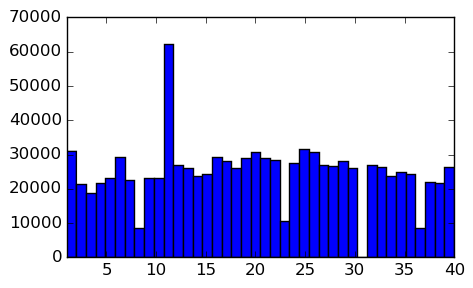

In [64]:
using PyPlot
figure("hist",figsize=(5,3))
ax=axes()
axis([1 ,40, 0 ,70000])
ax[:hist]([findfirst(board,name) for name in results], bins=40);

In [65]:
# We have to implement most_common here at it is not found Julia libraries 
using StatsBase
function most_common(r)
    commonList=collect(zip(board,counts([findfirst(board,name)::Int for name in r])))
    sort!(commonList,by=x->x[2],rev=true)
end
most_common(results)

40-element Array{Tuple{SubString{ASCIIString},Int64},1}:
 ("JAIL",62334)
 ("E3",31568)  
 ("GO",30929)  
 ("R3",30848)  
 ("D3",30772)  
 ("R1",29312)  
 ("R2",29281)  
 ("D2",29122)  
 ("FP",28982)  
 ("E1",28300)  
 ("U2",28270)  
 ("D1",28182)  
 ("E2",27405)  
 ⋮             
 ("B2",23089)  
 ("T1",23073)  
 ("B1",22597)  
 ("H1",22138)  
 ("T2",21851)  
 ("A2",21656)  
 ("A1",21426)  
 ("CC1",18820) 
 ("CH2",10585) 
 ("CH3",8535)  
 ("CH1",8480)  
 ("G2J",0)     

We can see that `JAIL` is by far the most popular square (at a little over 6%), and that the three least popular squares (around 1%) are the three chance squares, `CH1`, `CH2`, and `CH3` (because 10 of the 16 chance cards send the player away from the square), and of course the "Go to Jail" square, square number 30 on the plot, which has a count of 0 because you can't end a turn there. The other squares are pretty evenly distributed at 2% to 3% each.

# Classy Monopoly

Some people might think that the "`global here`" is bad style. One way to eliminate global variables is to pack them up into objects.  We can do that by making a `Monopoly` class.  My personal preference would be that the "`global here`" declarations add less visual clutter, but I present this refactored version for those who prefer it.

In [66]:
type Monopoly
    board 
    CC 
    CH 
    here
    function Monopoly()
        this=new()
        this.board= """GO   A1 CC1 A2  T1 R1 B1  CH1 B2 B3
           JAIL C1 U1  C2  C3 R2 D1  CC2 D2 D3 
           FP   E1 CH2 E2  E3 R3 F1  F2  U2 F3 
           G2J  G1 G2  CC3 G3 R4 CH3 H1  T2 H2""" |> split
        this.CC = append!(["GO", "JAIL"], repeat(["?"],outer=[14]))
        this.CH = append!("GO JAIL C1 E3 H2 R1 R R U -3" |> split,  repeat(["?"],outer=[6]))
        shuffle!(this.CC)
        shuffle!(this.CH)
        this.here=1
        return this
    end
end

"""Simulate given number of steps of monopoly game, incrementing counter 
for current square after each step. Return a list of (square, count) pairs in order."""
function simulate(m::Monopoly,steps)
    counter=zeros(Int,40)
     doubles = 0
     for _=1:steps
        d1, d2 = rand(1:6), rand(1:6)
        goto(m, m.here + d1 + d2)
        doubles = (d1 == d2) ? (doubles + 1): 0
        if doubles == 3 || m.board[m.here] == "G2J"  
            goto(m, "JAIL")
        elseif startswith(m.board[m.here],"CC") || startswith(m.board[m.here],"CH")
            do_card(m)
        end
        counter[m.here]+=1
    end
    commonList=collect(zip(m.board,counter))
    sort!(commonList,by=x->x[2],rev=true)
end

"Go to destination square (a square number). Update 'here'."
function goto(m::Monopoly, square::Int)
    m.here = (square-1) % length(m.board)+1
end

"Go to destination square (a square name). Update 'here'."
function goto(m::Monopoly,square::AbstractString)
    m.here = findfirst(m.board,square)
end

"Take the top card from deck and do what it says."
function do_card(m::Monopoly)
    deck= startswith(m.board[m.here],"CC") ? m.CC: m.CH #Which deck based on location
    card = pop!(deck)           # The top card
    unshift!(deck,card)           # Move top card to bottom of deck
    if card == "R"|| card == "U" 
        while !startswith(m.board[m.here],card)
            goto(m,m.here + 1)   # Advance to next railroad or utility
        end
    elseif card == "-3"
        before=m.here
        goto(m,m.here - 3)       # Go back 3 spaces
        if m.here==0
            println(before, " ",card)
        end
    elseif card != "?"
        goto(m,card)           # Go to destination named on card
    end
 
end
                    
simulate(Monopoly(),10^6)

40-element Array{Tuple{SubString{ASCIIString},Int64},1}:
 ("JAIL",62236)
 ("E3",31844)  
 ("D3",30896)  
 ("GO",30867)  
 ("R3",30597)  
 ("R1",29749)  
 ("D2",29285)  
 ("R2",29194)  
 ("E1",28629)  
 ("FP",28409)  
 ("U2",27952)  
 ("D1",27796)  
 ("E2",27257)  
 ⋮             
 ("B2",23390)  
 ("B3",23038)  
 ("B1",22504)  
 ("H1",22010)  
 ("T2",21926)  
 ("A2",21583)  
 ("A1",21424)  
 ("CC1",18934) 
 ("CH2",10736) 
 ("CH3",8733)  
 ("CH1",8165)  
 ("G2J",0)     

# The St. Petersburg Paradox

One more famous paradox:  The [St. Petersburg paradox](https://en.wikipedia.org/wiki/St._Petersburg_paradox) from 1713, named for the home town of the [Bernoulli brothers](http://www.storyofmathematics.com/18th_bernoulli.html):

> A casino offers a game of chance for a single player in which a fair coin is tossed at each stage. The pot starts at 2 dollars and is doubled every time a head appears. The first time a tail appears, the game ends and the player wins whatever is in the pot. Thus the player wins 2 dollars if a tail appears on the first toss, 4 dollars if a head appears on the first toss and a tail on the second, etc. What is the expected value of this game to the player?

To calculate the expected value, we see there is a 1/2 chance of a tail on the first toss (yielding a pot of \$2) and if not that, a 1/2 &times; 1/2 = 1/4 chance of a tail on the second toss (yielding a pot of \$4), and so on. So in total, the expected value is:

$$\frac{1}{2}\cdot 2 + \frac{1}{4}\cdot 4 + \frac{1}{8}\cdot 8 + \frac{1}{16} \cdot 16 + \cdots = 1 + 1 + 1 + 1 + \cdots = \infty$$

The expected value is infinite! But anyone playing the game would not expect to win an infinite amount; thus the paradox.

## Response 1: Limited Resources

The first major response to the paradox is that the casino's resources are limited. Once you break their bank, they can't pay out any more, and thus the expected return is finite. Let's model that by creating a probability distribution for the problem with a limited bank. We keep doubling the pot and halving the probability of winning the amount in the pot (half because you get the pot on a tail but not a head), until we reach the limit:

In [67]:
"Return the probability distribution for the St. Petersburg Paradox with a limited bank."
function st_pete(limit)
    P = Dict()     # The probability distribution
    pot = 2    # Amount of money in the pot
    pr  = 1/2 # Probability that you end up with the amount in pot
    while pot < limit 
        P[pot] = pr
        pot, pr = pot * 2, pr / 2
    end
    P[limit] = pr * 2               # pr * 2 because you get limit for heads or tails
    assert(sum(values(P)) == 1.0)
    sort(collect(zip(keys(P),values(P))))
end

StP = st_pete(10^9)

30-element Array{Tuple{Any,Any},1}:
 (2,0.5)                          
 (4,0.25)                         
 (8,0.125)                        
 (16,0.0625)                      
 (32,0.03125)                     
 (64,0.015625)                    
 (128,0.0078125)                  
 (256,0.00390625)                 
 (512,0.001953125)                
 (1024,0.0009765625)              
 (2048,0.00048828125)             
 (4096,0.000244140625)            
 (8192,0.0001220703125)           
 ⋮                                
 (524288,1.9073486328125e-6)      
 (1048576,9.5367431640625e-7)     
 (2097152,4.76837158203125e-7)    
 (4194304,2.384185791015625e-7)   
 (8388608,1.1920928955078125e-7)  
 (16777216,5.960464477539063e-8)  
 (33554432,2.9802322387695312e-8) 
 (67108864,1.4901161193847656e-8) 
 (134217728,7.450580596923828e-9) 
 (268435456,3.725290298461914e-9) 
 (536870912,1.862645149230957e-9) 
 (1000000000,1.862645149230957e-9)

Now we define the function `EV` to compute the [expected value](https://en.wikipedia.org/wiki/Expected_value) of the (limited) St. Petersburg probability distribution:

In [68]:
"The expected value of a probability distribution."
EV(P) =sum([v[1] * v[2] for v in P]);

In [69]:
EV(StP)

30.862645149230957

This says that for a casino with a bankroll of a billion dollars, you should be willing to pay \$30.86 to play the game. Would you pay that much? I wouldn't, and neither would Daniel Bernoulli. 

## Response 2: Value of Money

Bernoulli came up with a second response to the paradox based on the idea that if you have a lot of money, then additional money becomes less valuable to you. How much less valuable? Bernoulli proposed, and [experiments confirm](https://books.google.com/books?id=1oEa-BiARWUC&pg=PA205&lpg=PA205&dq=mr+beard+oil+wildcatter+value+of+money+utility&source=bl&ots=cBDIX-rkTz&sig=GHB8-inorWrU39vA8JYV_sCtqB8&hl=en&sa=X&ved=0CCAQ6AEwAGoVChMI5fu-p8qlyAIViKWICh0XAAz5#v=onepage&q=mr%20beard%20oil%20wildcatter%20value%20of%20money%20utility&f=false), that *the value of money is roughly logarithmic.* The idea is that if I had very little money, and I won \$1000, I would be very happy. But if I already had a million dollars and I won \$1000, it would make less difference to me; the \$1000 would be less valuable.  

I'll write the function `util` to describe what a dollar amount is worth to a hypothetical gambler. `util` says that a dollar is worth a dollar, until the amount is "enough" money. After that point, each additional dollar is worth half as much (only brings half as much happiness). Value keeps accumulating at this rate until we reach the next threshold of "enough," when the utility of additional dollars is halfed again. The exact details of `util` are not critical; what matters is that overall money becomes less valuable after we have won a lot of it.

In [70]:
"The value of money: only half as valuable after you already have enough."
function util(dollars, enough=1000)
    if dollars < enough
        return dollars
    else
        return enough + util((dollars-enough)/2., enough*2)
    end
end;

A table and a plot will give a feel for the `util` function. Notice the characterisitc concave-down shape of the plot.

In [71]:
for d=2:10
    println(lpad(10^d,15)," \$ = ",lpad(round(Int,util(10^d)),10), " util")
end

            100 $ =        100 util
           1000 $ =       1000 util
          10000 $ =       4250 util
         100000 $ =      15938 util
        1000000 $ =      51594 util
       10000000 $ =     162461 util
      100000000 $ =     535646 util
     1000000000 $ =    1658229 util
    10000000000 $ =    5171073 util


Y axis is util(x); x axis is in thousands of dollars.


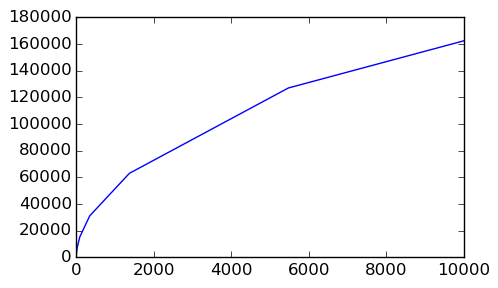

In [72]:
figure("Value of Money",figsize=(5,3))
plot([util(x) for x=1000:1000:10000000])
println("Y axis is util(x); x axis is in thousands of dollars.")

Now I will define the function `EU`, which computes the [expected utility](http://wiki.lesswrong.com/wiki/Expected_utility) of the game:

In [73]:
"The expected utility of a probability distribution, given a utility function."
EU(P, U)= sum([e[2] * U(e[1]) for e in P]);

In [74]:
EU(StP, util)

13.101970414893003

That says we should pay up to \$13.10 to play the game, which sounds more reasonable than \$30.86.

# Understanding the St. Petersburg Problem Better through Simulation

Before I plunk down my \$13, I'd like to understand the game better. I'll write a simulation of the game:

In [75]:
flip()=rand(["head", "tail"])

"Simulate one round of the St. Petersburg game, and return the payoff."
function simulate_st_pete(limit=10^9)
    pot = 2
    while flip() == "head"
        pot = pot * 2
        if pot > limit
            return limit
        end
    end
    return pot
end;

I will run the simulation 100,000 times (with a random seed specified for reproducability) and make the results into a probability distribution:

In [76]:
srand(1234)
# With Julia to can take a few million samples at get the results instantly 
results = sort(map((z)->(z[1],z[2]),proportionmap([simulate_st_pete() for _=1:100_000])), by=x->x[1])

17-element Array{Any,1}:
 (2,0.50021)    
 (4,0.24995)    
 (8,0.12632)    
 (16,0.06167)   
 (32,0.03038)   
 (64,0.01543)   
 (128,0.00845)  
 (256,0.00376)  
 (512,0.00191)  
 (1024,0.00085) 
 (2048,0.00053) 
 (4096,0.00027) 
 (8192,0.00015) 
 (16384,4.0e-5) 
 (32768,4.0e-5) 
 (65536,1.0e-5) 
 (131072,3.0e-5)

In [77]:
EU(results, util) 

13.139574999999999

The results are about what you would expect: about half the pots are 2, a quarter are 4, and higher pots are more and more unlikely. The expected utility was just a little bit more than the theoretical expected utility (13.14 vs. 13.10).

In [78]:
EV(results)

19.82342

The expected value (19.82) is almost two thirds of the theoretical expected value (30.86). Why should there be such a big difference? I think the answer is *variance*. If I averaged an infinite number of rounds I would get 30.86, but if I can only average a finite number, most of the time I will get a result less than 30.86, and a very small number of times I will get an average very much larger than 30.86, because the round happened to include a very big (but very rare) pot.

To see better how things unfold, I will define a function to plot the running average of repeated rounds:

In [79]:
"For each element in the iterable, yield the mean of all elements seen so far." 
function running_averages(iterable)
    total, n = 0, 0
    function run_avg_task()
        for x in iterable
            total, n = total + x, n + 1
            produce(total / n)
            end
    end
    Task(run_avg_task)
end

"Plot the running average of calling the function n times."
function plot_running_averages(fn, n)
    plot(collect(running_averages([fn() for _=1:n])))
end;

Let's do ten repetitions of plotting 100,000 rounds each repetition:

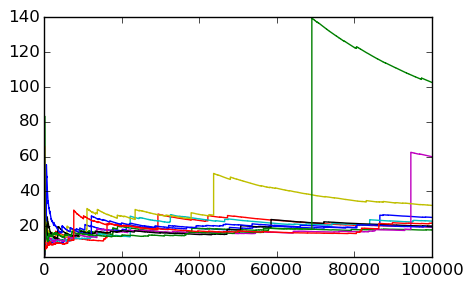

In [80]:
srand(555)
figure("Running Average",figsize=(5,3))
for i=1:10
    plot_running_averages(simulate_st_pete, 100000)
end
axis([1 ,100_000, 2, 140]);

What can we see from this?  Eight of the 10 repetitions have a final average payoff between 10 and 35. So a price around \$13 still seems reasonable. One outlier has an average payoff just over 100 and another just over 60, so if you are feeling lucky you might be willing to pay some amount between \$13 and \$30.

# Conclusion

We've seen how to manage probability paradoxes.  Just be explicit about what the problem says, and then methodical about defining the sample space, and finally be careful in counting the number of outcomes in the numerator and denominator. Easy as 1-2-3. But the bigger lesson is: treat those around you as reasonable people, and when they have different opinons, try to discover what problem they are  solving.